variational AUTOENCODER ON EXTRACTED FEATURES

In [1]:
#activate conda env AutencoderTF env tf '2.10.0' , python 3.9.16
import tensorflow as tf
from skimage.metrics import mean_squared_error, normalized_root_mse,normalized_mutual_information
from sklearn.preprocessing import normalize, MinMaxScaler


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from alive_progress import  alive_bar
import torch
import sys
from pathlib import Path
import os

print(sys.path)
sys.path.append('c:\\Users\\buehl\\Dropbox\\ZHAW\\MSE_DataScience\\23FS\\VT2\\Anomaly_detection_images\\bosch_AD\\LatentOE-AD')
from loader.LoadData import CIFAR10_feat , FMNIST_feat
from Additional_Code_BULE.utils.helper_functions  import *
from Additional_Code_BULE.utils.VAE_models_Torch  import *

from skimage.metrics import mean_squared_error, normalized_root_mse,normalized_mutual_information
from sklearn.preprocessing import normalize, MinMaxScaler

print(f'tensorflow_version: {tf.__version__}')
print(f'torch_version: {torch.__version__}')
print("Tensorflow: Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f'GPU for pytorch: {torch.cuda.is_available()}')

root="C:/Users/buehl/Dropbox/ZHAW/MSE_DataScience/23FS/VT2/Anomaly_detection_images/bosch_AD/LatentOE-AD/DATA/fmnist_features/"

['c:\\Users\\buehl\\Dropbox\\ZHAW\\MSE_DataScience\\23FS\\VT2\\Anomaly_detection_images\\bosch_AD\\LatentOE-AD\\Additional_Code_BULE', 'c:\\Users\\buehl\\git\\projects\\LatentOE-AD', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\python39.zip', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\DLLs', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\lib', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF', '', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\lib\\site-packages', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\lib\\site-packages\\win32', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\lib\\site-packages\\win32\\lib', 'c:\\Users\\buehl\\anaconda3\\envs\\AutencoderTF\\lib\\site-packages\\Pythonwin']
tensorflow_version: 2.10.1
torch_version: 2.0.1
Tensorflow: Num GPUs Available:  1
GPU for pytorch: True


In [2]:
# https://avandekleut.github.io/vae/

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

starting to calculate measures class: 0
starting to calculate measures class: 1
starting to calculate measures class: 2
starting to calculate measures class: 3
starting to calculate measures class: 4
starting to calculate measures class: 5
starting to calculate measures class: 6
starting to calculate measures class: 7
starting to calculate measures class: 8
starting to calculate measures class: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   mse_           100000 non-null  float64
 1   csim_          100000 non-null  float64
 2   anomaly_       100000 non-null  int64  
 3   normal_label_  100000 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.1 MB


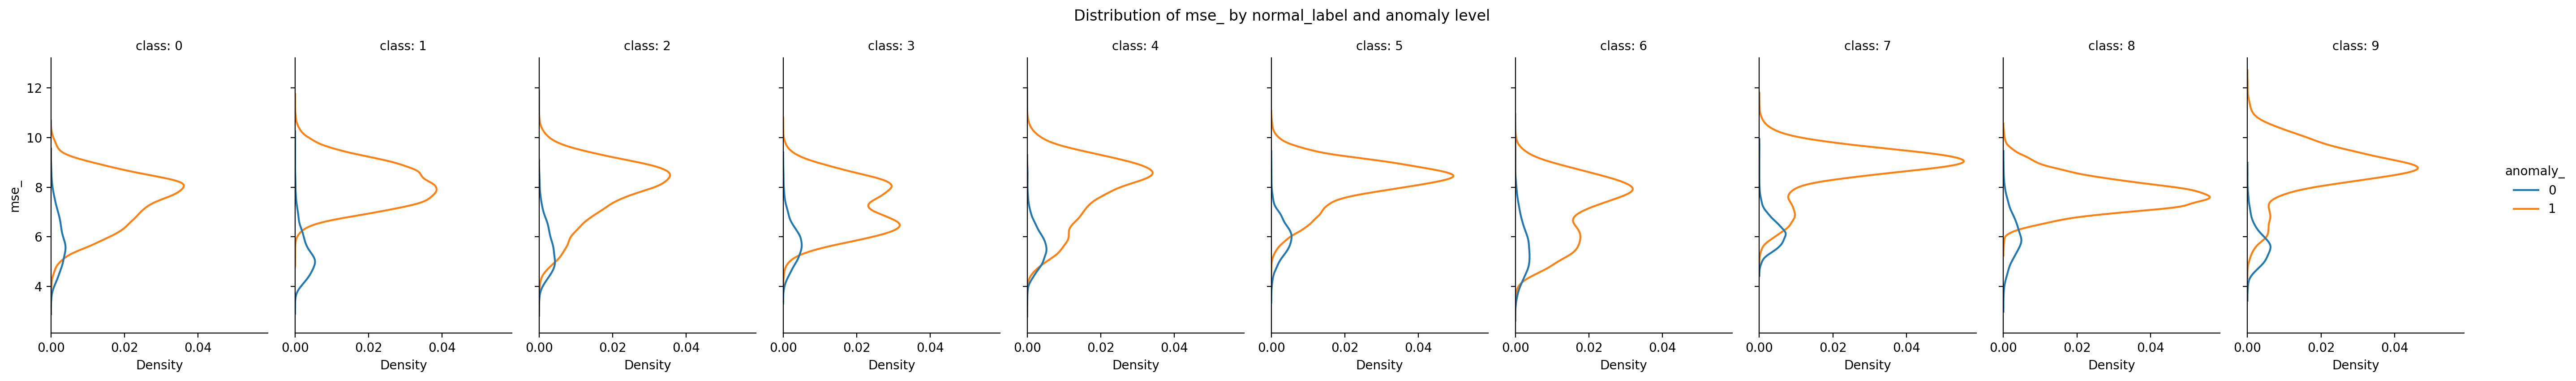

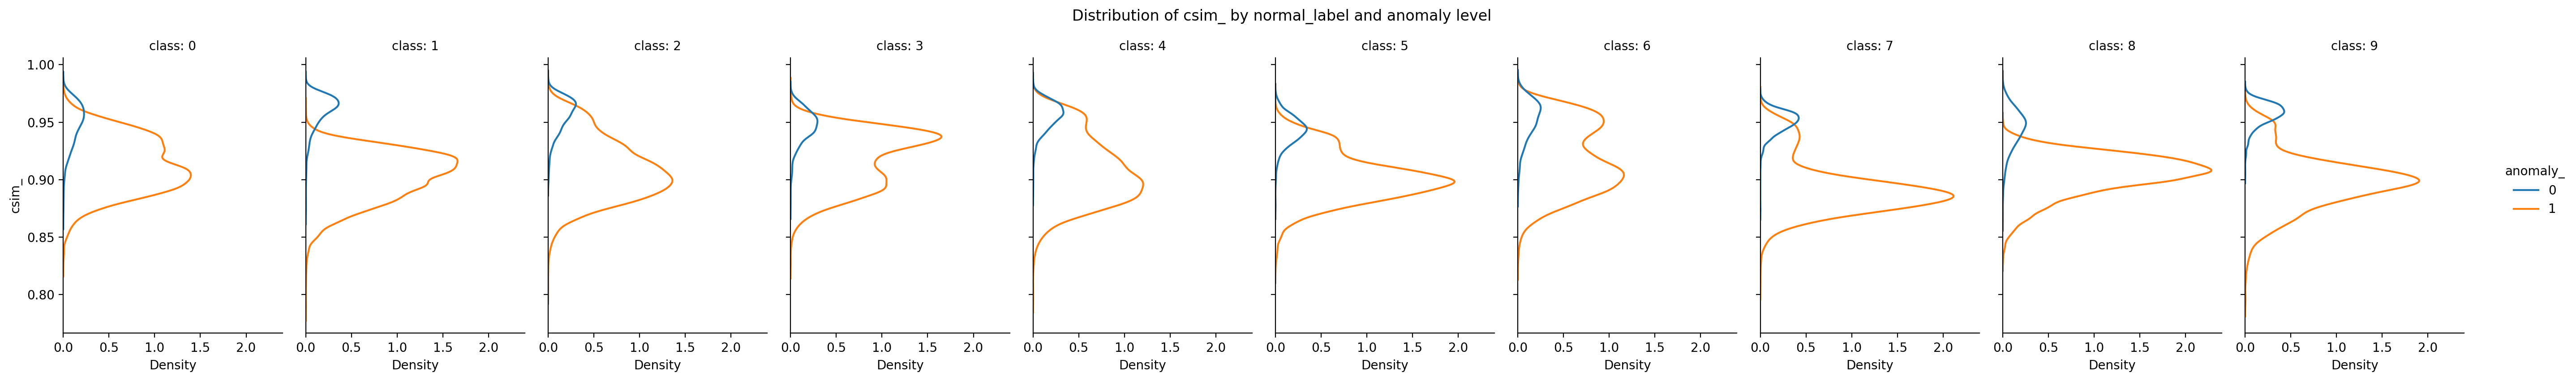

In [140]:
np.random.seed(42)
labels=[0,1,2,3,4,5,6,7,8,9]

pmi,mse,nrmse,csim,normal_label,anomaly=[],[],[],[],[],[]

for i in labels:
    # load data for each class
    x_train, y_train, x_test, y_test = FMNIST_feat(i,root=root,contamination_rate=0.0)
    #x_train= x_train.numpy()
    #x_test= x_test.numpy()

    ##transformation of features
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train=torch.tensor(np.sqrt(scaler.transform(x_train)),dtype=torch.float32)

    scaler = MinMaxScaler()
    scaler.fit(x_test)
    x_test=torch.tensor(np.sqrt(scaler.transform(x_test)),dtype=torch.float32)
    
    # instantiate model & fit to data
    latent_dims=64
    vae = VariationalAutoencoder(latent_dims).to(device) # GPU
    vae = train(vae, x_train.to(device), epochs=10)
        
    # #testing on 1000 normal samples and 9000 anomalies per i
    # decoded_imgs = vae(x_test.to(device)).to(device)
    # print(len(decoded_imgs))
    print(f"starting to calculate measures class: {i}")
    for j in range(0,len(x_test)):
        
        predicted_sample_j = (vae(x_test[j].to(device)).reshape(2048)).detach()
        original_sample_j = x_test[j].to(device)

        mse.append(torch.norm(predicted_sample_j - original_sample_j, 2).cpu().numpy())
        csim.append(F.cosine_similarity(predicted_sample_j.unsqueeze(0), original_sample_j.unsqueeze(0)).cpu().numpy())
        # nrmse.append(normalized_root_mse(original_sample_j,predicted_sample_j))
        # pmi.append(normalized_mutual_information(original_sample_j,predicted_sample_j-1))
        normal_label.append(i)
        anomaly.append(y_test[j])


# creating a pandas dataset
csim=[value.item() for value in csim]
only_clean = pd.DataFrame({'mse_': mse,'csim_':csim,'anomaly_':anomaly,'normal_label_':normal_label})#, 
# converting datatypes
only_clean['mse_']=only_clean['mse_'].astype(str).astype(float)
only_clean['csim_']=only_clean['csim_'].astype(str).astype(float)
only_clean.info()



# plotting the values
plt.rcParams["figure.figsize"] = (30,10)
for metric in [name for name in list(only_clean) if name not in ['anomaly_', 'normal_label_'] ]:
    g = sns.displot(data=only_clean, y=metric, hue="anomaly_", col="normal_label_",kind="kde", height=4, aspect=.7,)
    g.set_axis_labels("Density", metric)
    g.set_titles("class: {col_name}")
    g.fig.suptitle(f"Distribution of {metric} by normal_label and anomaly level ", y=1.05)

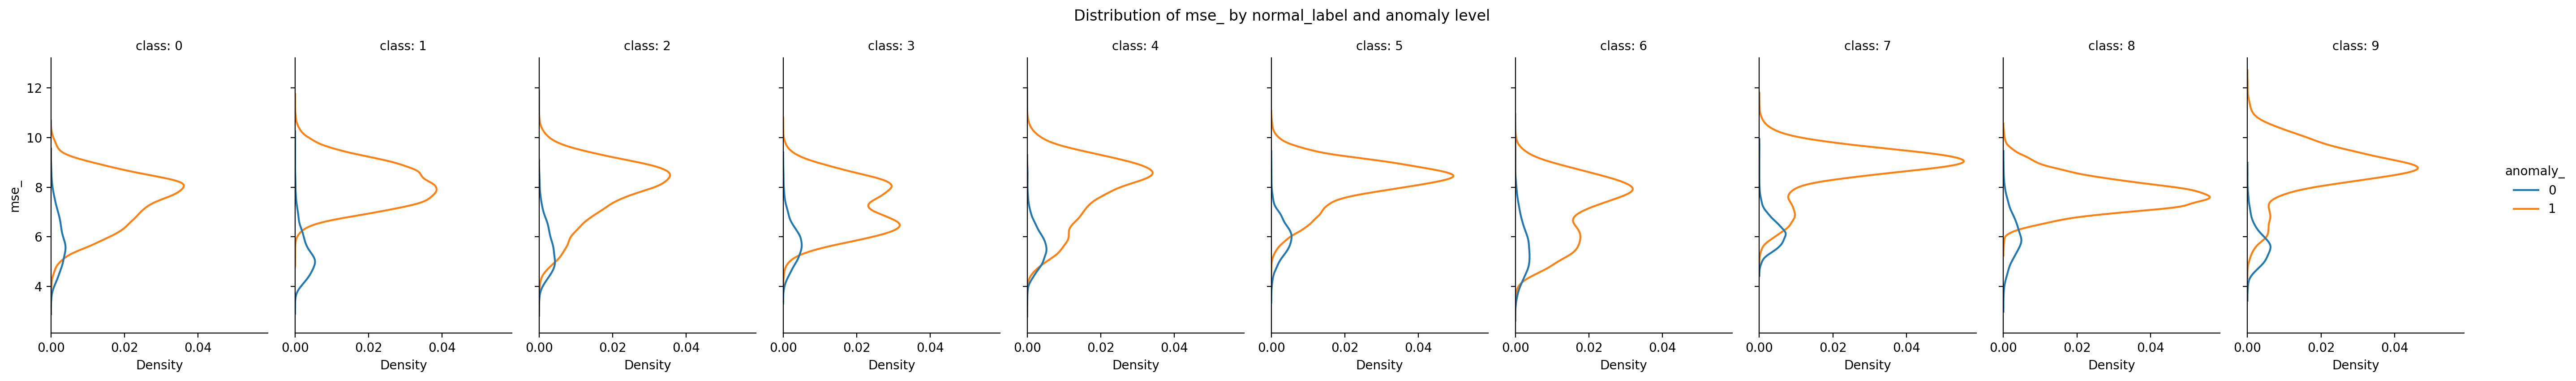

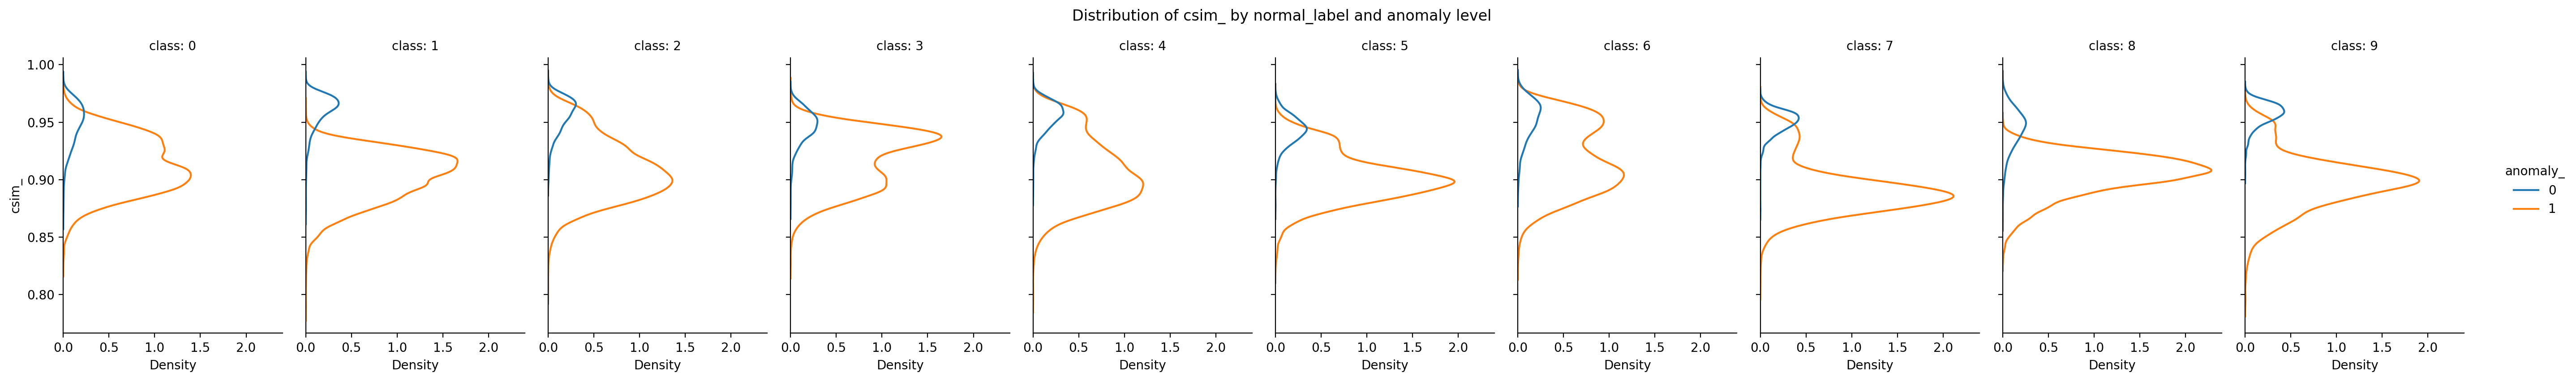

In [141]:
plt.rcParams["figure.figsize"] = (30,10)
for metric in [name for name in list(only_clean) if name not in ['anomaly_', 'normal_label_'] ]:
    g = sns.displot(data=only_clean, y=metric, hue="anomaly_", col="normal_label_",kind="kde", height=4, aspect=.7,)
    g.set_axis_labels("Density", metric)
    g.set_titles("class: {col_name}")
    g.fig.suptitle(f"Distribution of {metric} by normal_label and anomaly level ", y=1.05)


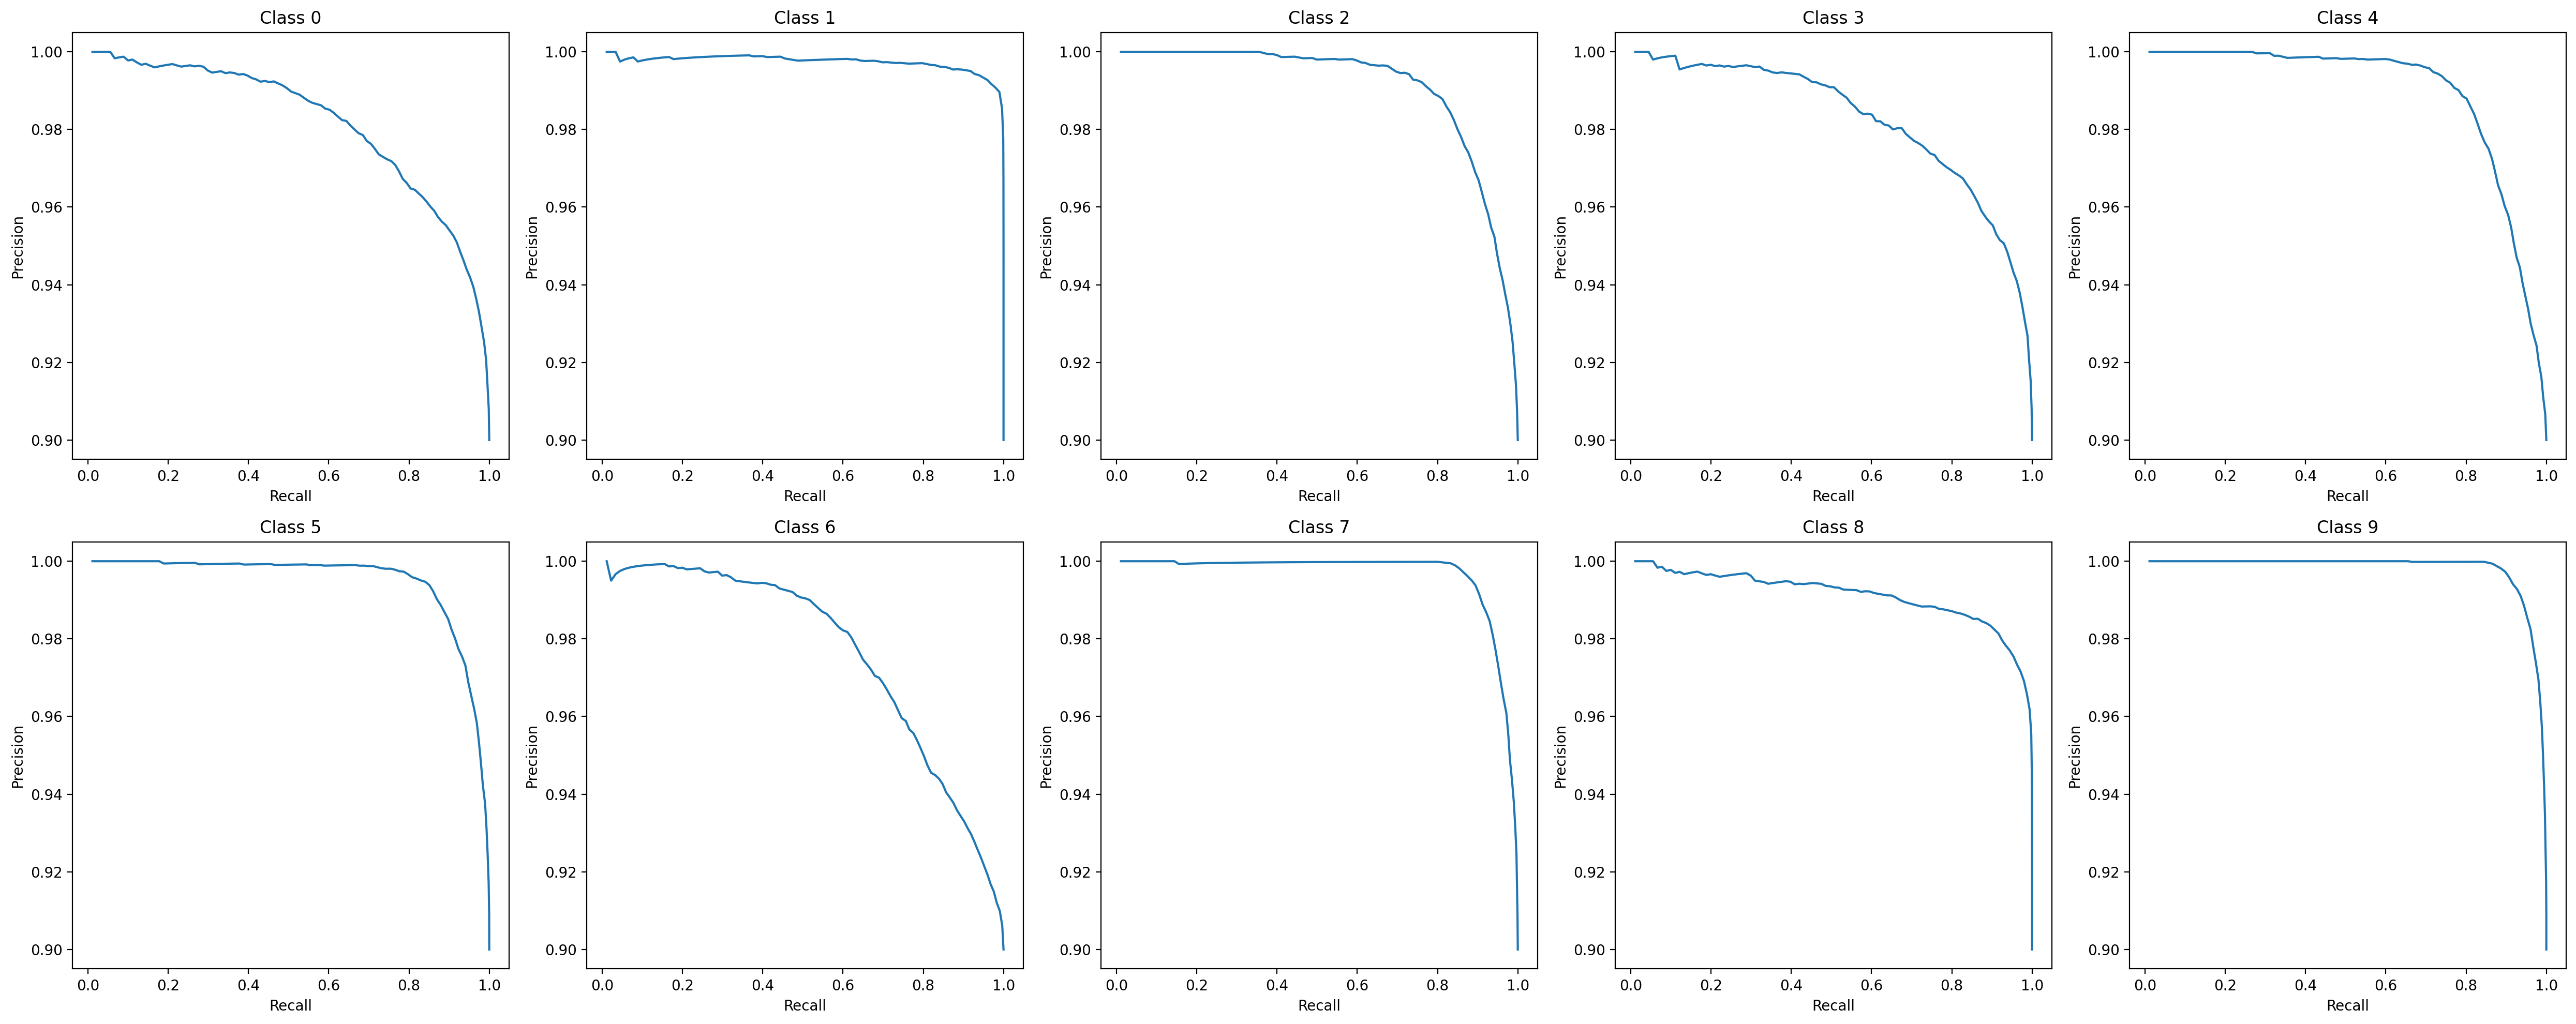

In [147]:
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = range(10)

fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots

for i, class_label in enumerate(class_labels):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    subset_mse = only_clean[only_clean["normal_label_"] == class_label]["mse_"]
    subset_anomaly = only_clean[only_clean["normal_label_"] == class_label]["anomaly_"]

    quantile_list = np.arange(0, 1, 0.01)
    precision, recall = [], []

    for quantile in quantile_list:
        thresh = np.quantile(subset_mse, quantile)
        predict = np.zeros_like(subset_mse)  # predictions are all normals
        idxs = np.where(np.array(subset_mse) >= thresh)[0]  # all anomalies
        predict[idxs] = 1

        tn, fp, fn, tp = confusion_matrix(subset_anomaly, predict).ravel()
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))

    ax.plot(recall, precision)
    ax.set_title(f"Class {class_label}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

plt.tight_layout()
plt.show()

In [ ]:
#next maybe

# conditional VAE https://github.com/HongleiXie/demo-CVAE

In [12]:
from logging import log

In [9]:

results_df.rename(columns={'mse_': 'csim_', 'anomaly_': 'normal_label'}, inplace=True)

KeyError: 'contam_ratio'

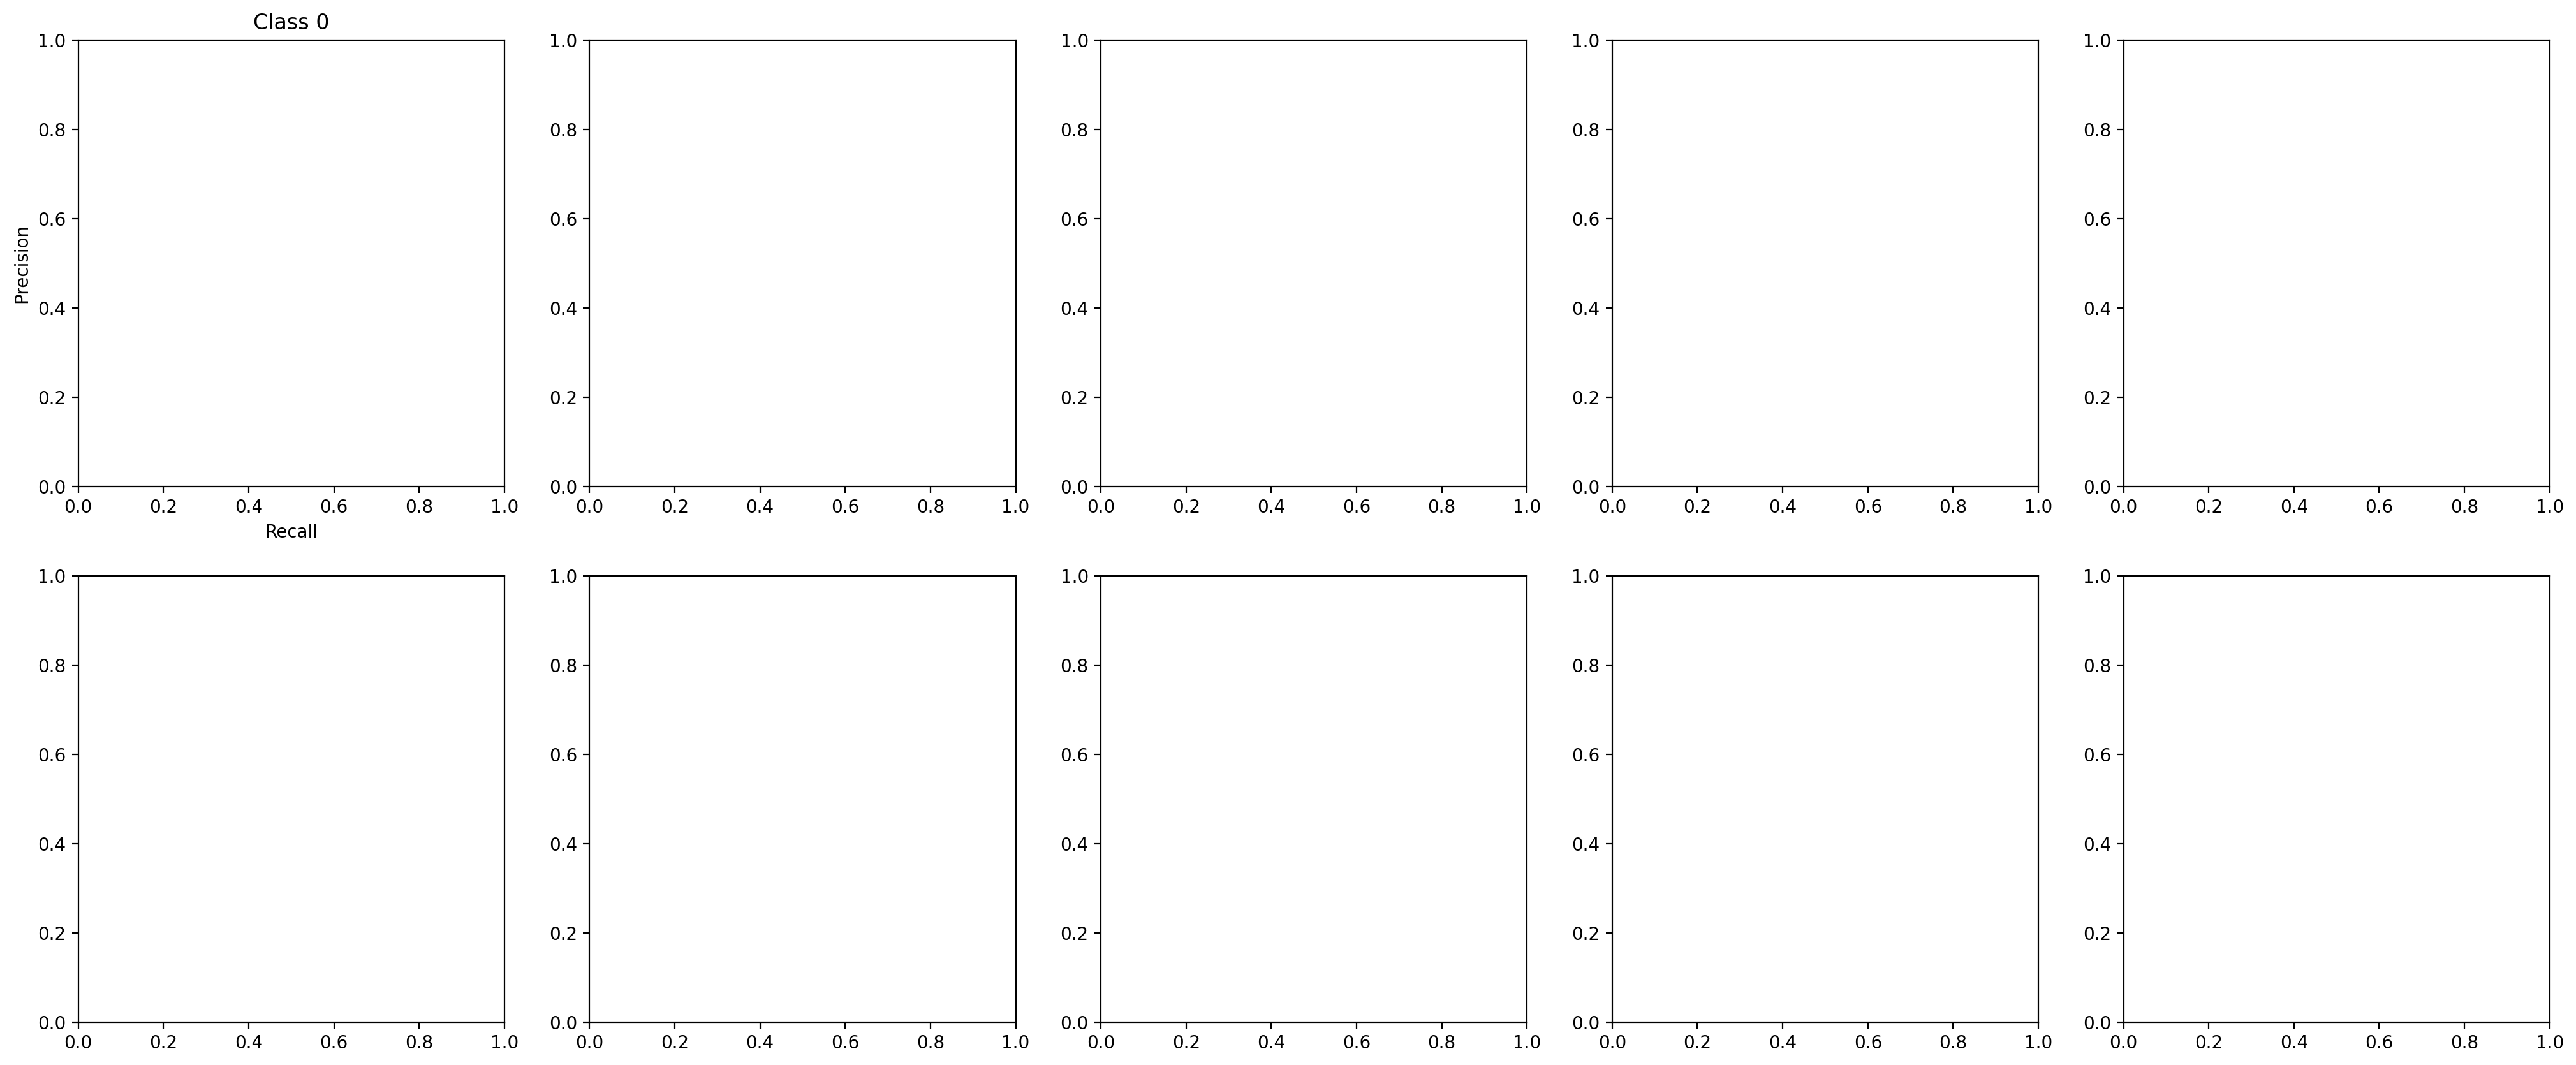

In [15]:
MODEL_RESULT_PATH = Path(r"C:\Users\buehl\Dropbox\ZHAW\MSE_DataScience\23FS\VT2\Anomaly_detection_images\bosch_AD\LatentOE-AD\RESULTS\fmnist\VAE")

# calculate recall precision + plot for 1 contamination ratio 

# TODO separate plot from calculation

from sklearn.metrics import precision_recall_curve

plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def precision_recall_single_contam(dataframe, plot=True):
    """
    calculates precison recall for all the 

    """
    
    class_labels = list(set(dataframe['normal_label']))

    #contam_list = list(set(dataframe['contam_ratio']))
    contam_list=[0.1,0.2,0.3,0.4]

    
    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots

    for i, class_label in enumerate(class_labels):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.set_title(f"Class {class_label}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")

        handles = []  # List to store plot handles for legend

        for ratio in contam_list:
            subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
            subset_mse = subset["mse_"]
            subset_anomaly = subset["anomaly_"]
            precision, recall = precision_recall(subset_mse, subset_anomaly,thresh_larger=False)# my implementaion

            #precision, recall, _ = precision_recall_curve(subset_anomaly, subset_mse)#sklearn pr  calc
            # TODO  add metric

            if plot:
                handle, = ax.plot(recall, precision)  # Store the plot handle
                handles.append(handle)

    if plot:
        plt.tight_layout()

        # Create the legend using plot handles and labels
        plt.legend(handles, contam_list, loc='best', title="Ratios")
        
        plt.show()


results_df=pd.read_pickle(os.path.join(MODEL_RESULT_PATH,f"Variational_Autoencoder_features_allresults.pkl"))
results_df.rename(columns={'mse_': 'csim_', 'anomaly_': 'normal_label'}, inplace=True)
precision_recall_single_contam(results_df,plot=True)